# Load the model


In [64]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import RobustScaler
from keras.models import load_model
from tvDatafeed import TvDatafeedLive, Interval, TvDatafeed
from joblib import dump, load

In [57]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


# Load the model 


In [58]:
model = load_model('model_after(split.8)_process_iter_0.h5')

# Download Data


In [43]:
def download_data(symbol, exchange, interval, n_bars = 5000):
    datafeed = TvDatafeedLive()
    try:
        data = datafeed.get_hist(
            symbol=symbol,
            exchange=exchange,
            interval=interval,
            n_bars=n_bars
            
        )
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

# Load Data 

In [68]:
sequence_length = 5

In [70]:
def load_data():
        
    # Load the test dataset
    test_data = pd.read_csv("15m_data_from_14_3_to_22_3 .csv")  # Your new test data file

    # Convert the 'datetime' column to datetime format
    test_data['datetime'] = pd.to_datetime(test_data['datetime'])

    # Sort the data by datetime (if not already sorted)
    test_data = test_data.sort_values(by='datetime')

    # Extract only the 'close' column
    test_close_prices = test_data['close'].values.reshape(-1, 1)  # Reshape to 2D array for scaling

    # Create a new scaler for the test data
    # Note: In practice, you should use the same scaler that was fit on your training data
    scaler = load('scaler.joblib')

    test_scaled = scaler.fit_transform(test_close_prices)

    # Define sequence length (same as in your original code)


    # Create sequences for testing data
    X_test_new = []
    y_test_new = []
    for i in range(len(test_scaled) - sequence_length):
        X_test_new.append(test_scaled[i:i + sequence_length].flatten())  # Flatten the sequence
        y_test_new.append(test_scaled[i + sequence_length])
    X_test_new = np.array(X_test_new)
    y_test_new = np.array(y_test_new)

    # If you need the original values
    y_test_new_original = scaler.inverse_transform(y_test_new.reshape(-1, 1))

    # Print shapes to verify
    print("X_test_new shape:", X_test_new.shape)
    print("y_test_new shape:", y_test_new.shape)
    return X_test_new, y_test_new, y_test_new_original, scaler, test_data

    

In [76]:
data = download_data('XAUUSD', 'FOREXCOM', Interval.in_1_minute, n_bars=10000 )
print(type(data))
data.to_csv('1data_1m.csv')


<class 'pandas.core.frame.DataFrame'>


In [60]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


In [ ]:
def evalu(predictions, y_test_original):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"Price Accuracy: {1 - mape}")
    print(f"Direction Accuracy: {dir_acc}\n")

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


X_test_new shape: (388, 5)
y_test_new shape: (388, 1)
Predictions shape: (388, 1)

First few predictions:
[[3086.58349609]
 [3086.58227539]
 [3086.58178711]
 [3086.58178711]
 [3086.58227539]]

Actual vs Predicted:
Actual: 2995.88, Predicted: 3086.58
Actual: 2996.04, Predicted: 3086.58
Actual: 2996.53, Predicted: 3086.58
Actual: 2997.23, Predicted: 3086.58
Actual: 2997.11, Predicted: 3086.58
MAE: 56.37894503563949
MAPE: 0.018629542850572247
Price Accuracy: 0.9813704571494277
Direction Accuracy: 0.49468180998738054



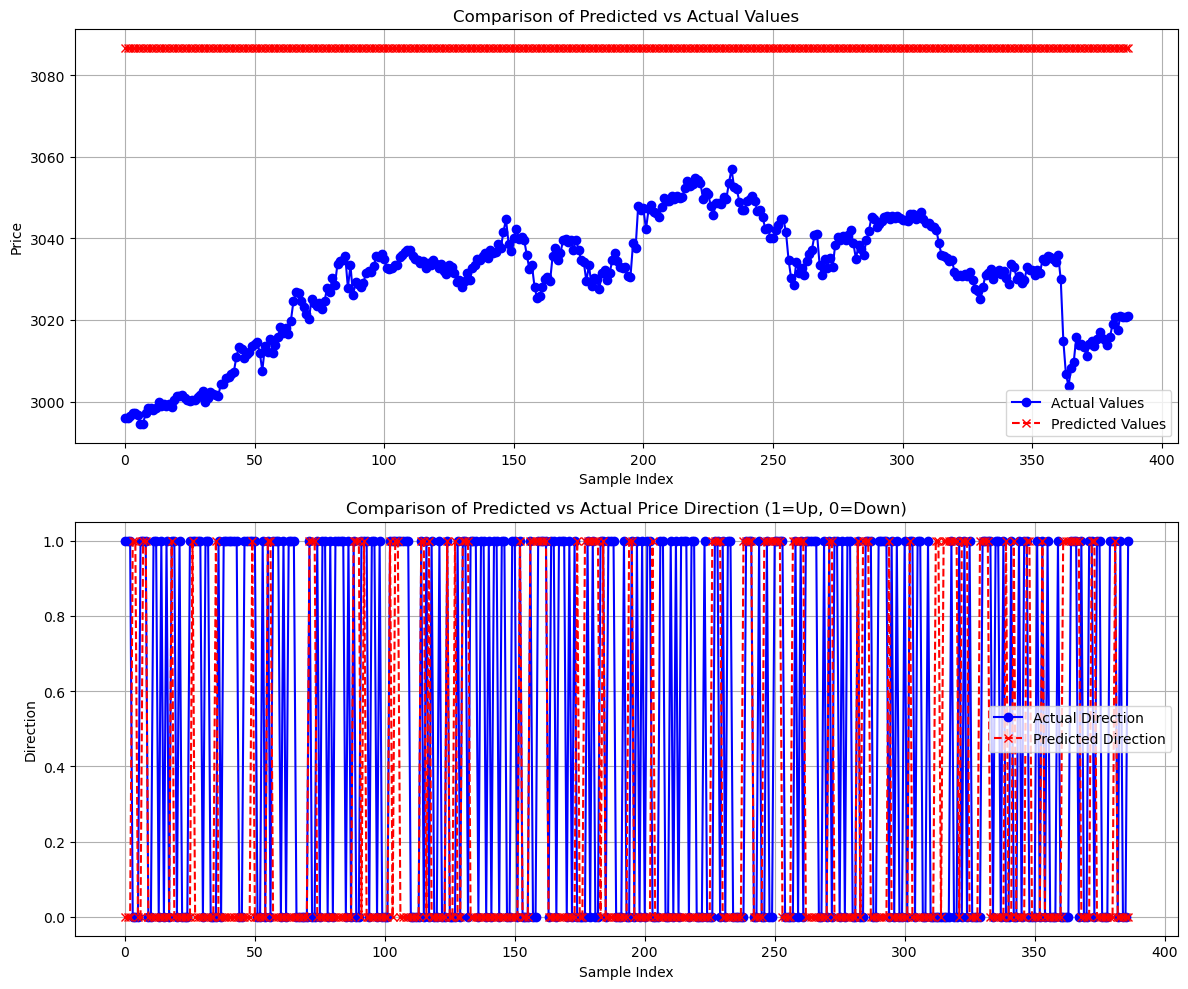

In [71]:
import numpy as np


# Assuming your new test data is already preprocessed as X_test_new from the previous code
# and your model is already loaded as 'model'
X_test_new, y_test_new, y_test_new_original, scaler, test_data = load_data()


# Initialize array for results
results_new = np.zeros((len(X_test_new), 1))

# Make predictions
for j in range(len(X_test_new)):
    current_input = X_test_new[j].reshape(1, sequence_length)
    prediction = model.predict(current_input, verbose=0)
    results_new[j] = scaler.inverse_transform(prediction.reshape(-1, 1))

# Print some results
print("Predictions shape:", results_new.shape)
print("\nFirst few predictions:")
print(results_new[:5])

# If you want to compare with actual values
actual_prices = test_data['close'][sequence_length:].values
print("\nActual vs Predicted:")
for i in range(5):  # Print first 5 comparisons
    print(f"Actual: {actual_prices[i]:.2f}, Predicted: {results_new[i][0]:.2f}")




evalu(results_new, actual_prices)